# Отток клиентов

### Описание данных

**Признаки**  

*`RowNumber`* — индекс строки в данных  
*`CustomerId`* — уникальный идентификатор клиента  
*`Surname`* — фамилия  
*`CreditScore`* — кредитный рейтинг  
*`Geography`* — страна проживания  
*`Gender`* — пол  
*`Age`* — возраст  
*`Tenure`* — сколько лет человек является клиентом банка  
*`Balance`* — баланс на счёте  
*`NumOfProducts`* — количество продуктов банка, используемых клиентом  
*`HasCrCard`* — наличие кредитной карты  
*`IsActiveMember`* — активность клиента  
*`EstimatedSalary`* — предполагаемая зарплата 

**Целевой признак**  

*`Exited`* — факт ухода клиента

### План работы

1. Описание проекта    
2. Подготовка данных  
    2.1 Предобработка данных   
    2.2 Подготовка признаков    
    2.3 Деление на features/target    
3. Исследование задачи  
    3.1 Исследование баланса классов целевого признака  
    3.2 Модели без баланса классов  
4. Борьба с дисбалансом  
    4.1 Взвешивание классов  
    4.2 Upsampling  
    4.3 Изменение порога  
5. Тестирование моделей  
    5.1 Dummy Classifier  
    5.2 Метрики по моделям  
6. Вывод

## Подготовка данных

### Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import time

import random

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
pth1 = '/datasets/Churn.csv'
pth2 = 'datasets/Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.columns = df.columns.str.lower()
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


У нас есть данные - 14 колонок, 10000 строк, пропуски в одном столбце `tenure`. Посмотрим на данные поближе... Ниже я покручу данные - поищу какие-то взаимосвязи. Спойлер - зависимостей не обнаружено.

In [7]:
df['customerid'].nunique()

10000

In [8]:
df['surname'].nunique()

2932

In [9]:
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [10]:
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [11]:
df['numofproducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: numofproducts, dtype: int64

In [12]:
df['hascrcard'].value_counts()

1    7055
0    2945
Name: hascrcard, dtype: int64

In [13]:
df['isactivemember'].value_counts()

1    5151
0    4849
Name: isactivemember, dtype: int64

In [14]:
len(df.loc[(df['isactivemember']==False) & (df['balance']==0)])

1744

In [15]:
len(df[df['balance']==0])

3617

In [16]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [17]:
df[['creditscore', 'age', 'balance', 'estimatedsalary']].describe()

,creditscore,age,balance,estimatedsalary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


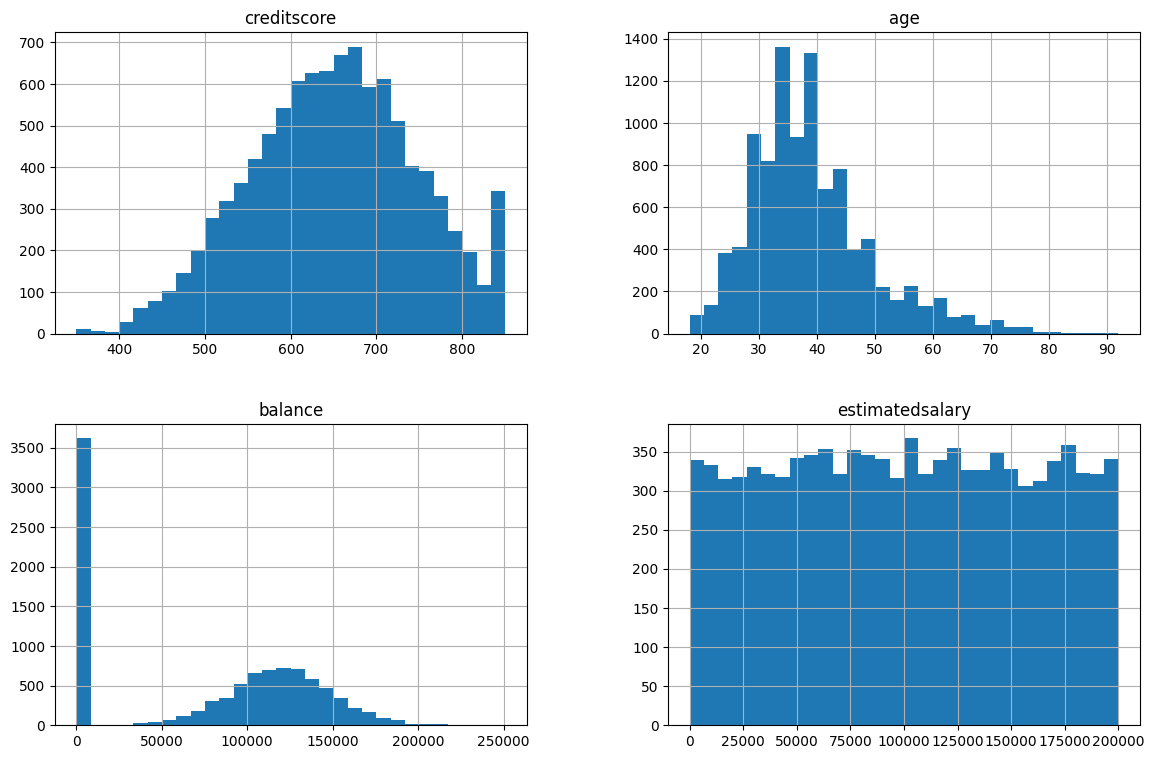

In [18]:
df[['creditscore', 'age', 'balance', 'estimatedsalary']].hist(bins=30, figsize=(14, 9))
None

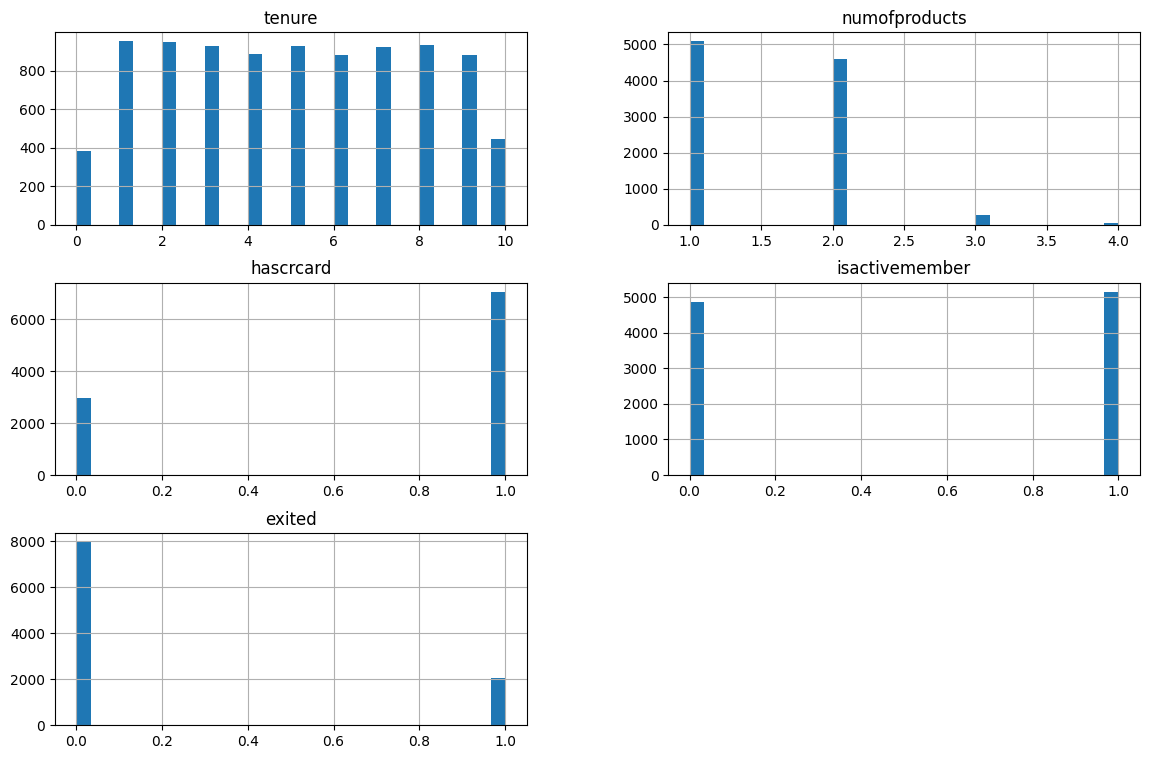

In [19]:
df[['geography', 'gender', 'tenure', 'numofproducts', 'hascrcard', 'isactivemember', 'exited']].hist(bins=30, figsize=(14, 9))
None

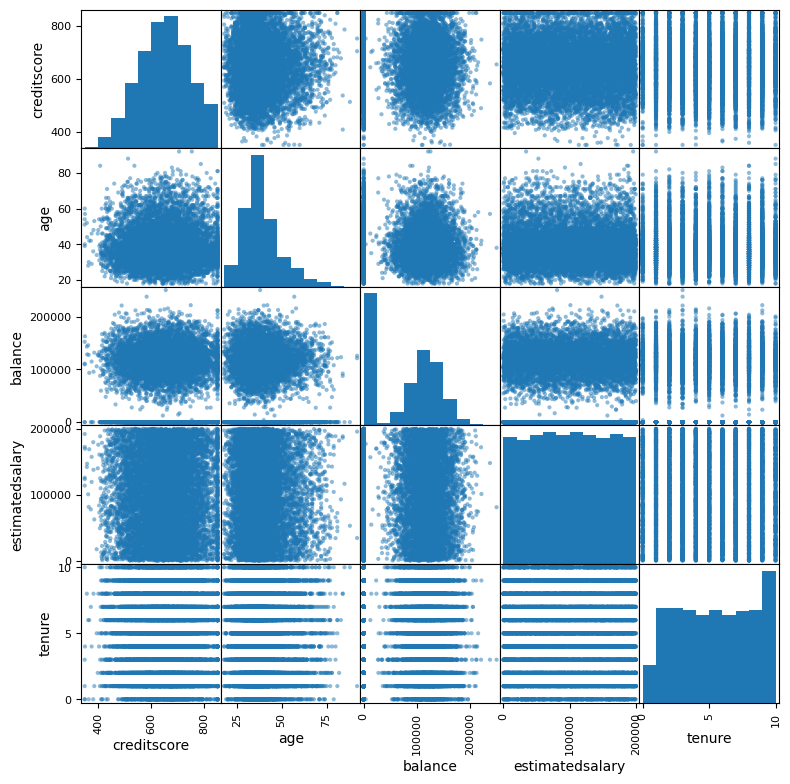

In [20]:
pd.plotting.scatter_matrix(df[['creditscore', 'age', 'balance', 'estimatedsalary', 'tenure']], figsize=(9, 9))
None

In [21]:
len(df[df['age'] > 70])

133

In [22]:
len(df[df['estimatedsalary'] < 50000])

2453

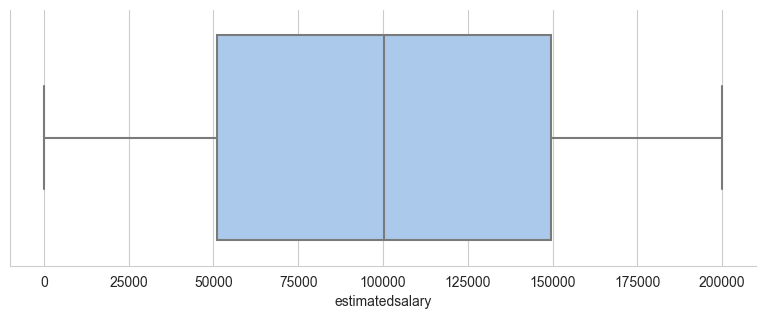

In [23]:
sns.set_style("whitegrid")
g = sns.catplot(x='estimatedsalary', kind="box", 
                data=df,
                palette = 'pastel')
g.fig.set_figwidth(8)
g.fig.set_figheight(3)
plt.show()
None

In [24]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [25]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [26]:
(df['tenure'].isna().sum()) / len(df)

0.0909

9.1% пропусков в столбце `tenure`. Посмотрим на взаимосвязь признаков с 'tenure', чтобы заполнить пропуски наиболее удачно.

In [27]:
#  проверим, есть ли коррелирующий признак для "tenure"
column_list = ['creditscore', 'age', 'balance', 'numofproducts', 'estimatedsalary']
for column in column_list:
    print(column, df['tenure'].corr(df[column]).round(3))

creditscore -0.0
age -0.013
balance -0.008
numofproducts 0.012
estimatedsalary 0.011


Коэффициенты корреляции достаточно слабые. Посмотрим на взаимосвязь 'tenure' со страной проживания и возрастом клиентов.

In [28]:
df.pivot_table(columns='geography', values='tenure', aggfunc='count')

geography,France,Germany,Spain
tenure,4550,2293,2248


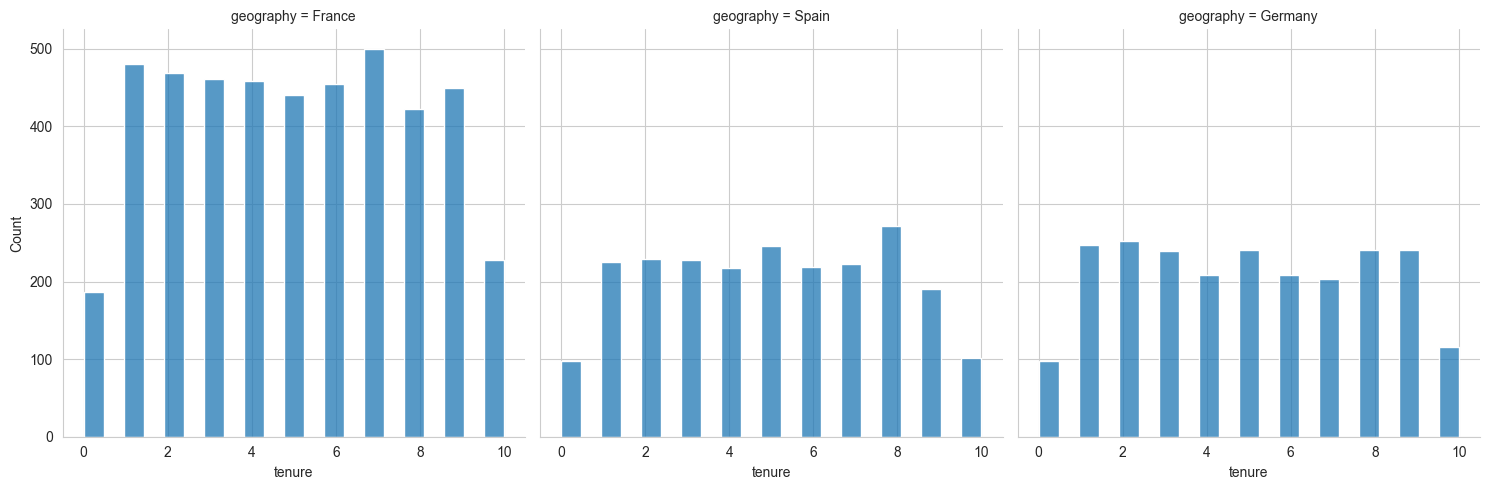

In [29]:
sns.displot(x='tenure',
            col='geography',
            data=df)

<Figure size 1000x1000 with 0 Axes>

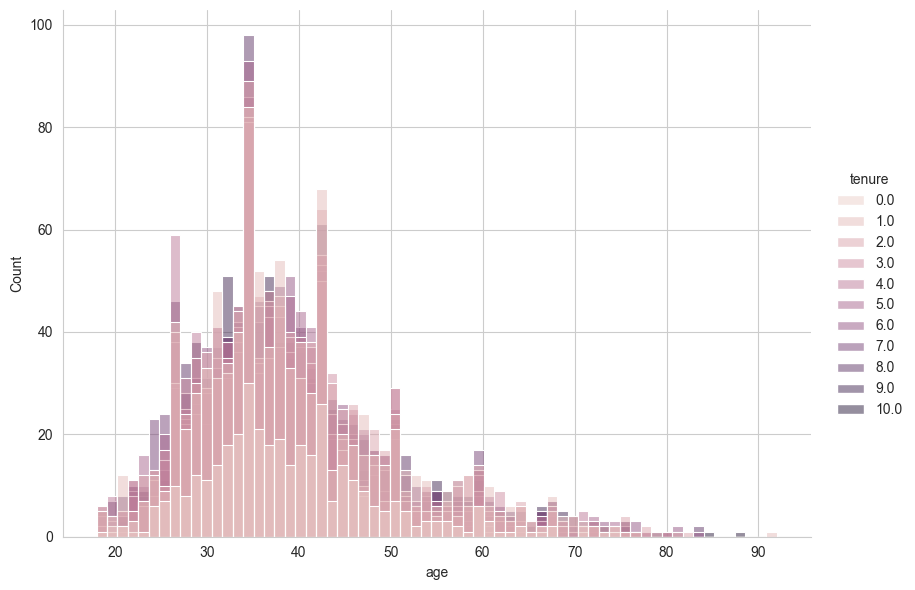

In [30]:
plt.figure(figsize=(10, 10))
sns.displot(x='age',
            hue='tenure',
            data=df,
            height=6, 
            aspect=1.4)

На графиках видно, что во Франции больше клиентов, примерно вдвое, чем в Испании или Германии, но рапределения примерно одинаковые для 'tenure' (0 и 10 лет - в меньшинстве, а средние значения плюс минус равномерно распределены). Для 'age' - видим нормальное распределение 'tenure'по годам.  
Заполним 'tenure' медианой по возрастным категориям.

In [31]:
df['age_group'] = pd.cut(df['age'], bins = [16, 25, 30, 35, 40, 45, 50, 60, 70, 80, 95])
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,age_group
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,"(40, 45]"
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,"(40, 45]"
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,"(40, 45]"
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,"(35, 40]"
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,"(40, 45]"


In [32]:
medians_tenure_age = df.groupby('age_group')['tenure'].transform('median')
df['tenure'] = df['tenure'].fillna(medians_tenure_age)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   rownumber        10000 non-null  int64   
 1   customerid       10000 non-null  int64   
 2   surname          10000 non-null  object  
 3   creditscore      10000 non-null  int64   
 4   geography        10000 non-null  object  
 5   gender           10000 non-null  object  
 6   age              10000 non-null  int64   
 7   tenure           10000 non-null  float64 
 8   balance          10000 non-null  float64 
 9   numofproducts    10000 non-null  int64   
 10  hascrcard        10000 non-null  int64   
 11  isactivemember   10000 non-null  int64   
 12  estimatedsalary  10000 non-null  float64 
 13  exited           10000 non-null  int64   
 14  age_group        10000 non-null  category
dtypes: category(1), float64(3), int64(8), object(3)
memory usage: 1.1+ MB


#### Вывод

1. Названия столбцов привела к нижнему регистру  
2. Количественные признаки:  
    2.1 кредитный рейтинг имеет пик в диапазоне 830-850 - выбивается из нормального распределения    
    2.2 возраст клиентов от 18 до 92 - нормальное распределение, артефактов не выявлено    
    2.3 большая доля клиентов с нулевым балансом - 3617 чел (36%) - половина которых (17%) относятся к категории неактивных клиентов  
    2.4 предполагаемая зарплата распределена равномерно - думаю, такое распределение специально было задумано для этого исследования, поэтому оставляю, как есть - не убираю возможно низкие значения.  
3. Категориальные признаки:  
    3.1 число продуктов - большинство клиентов имеют 1 или 2 (совсем мало 3 или 4)  
    3.2 карта есть у 70.6% клиентов  
    3.3 активных и неактивных клиентов 51.2% vs 48.8%  
    3.4 целвой признак - факт ухода клиентов - 20.4%  
    3.5 признак с пропусками (9.1%) - `tenure` - сколько лет человек является клиентом банка. Заполнила пропуски медианой по возрастным категориям.

### Подготовка признаков

In [33]:
# убираем столбцы,  не имеющие значения для работы модели
df = df.drop(['rownumber', 'customerid', 'surname', 'age_group'], axis=1)

In [34]:
# преобразуем категориальные строковые данные в числовые
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.columns = df_ohe.columns.str.lower()
df_ohe.sample(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
3451,607,21,0.0,0.00,2,1,0,116106.52,0,0,0,0
9680,590,36,1.0,0.00,2,1,0,48876.84,0,0,0,1
8739,518,59,5.0,138772.15,1,0,1,123872.00,0,0,0,1
1064,723,20,4.0,0.00,2,1,1,140385.33,0,0,0,0
7613,634,37,7.0,51582.50,2,1,1,184312.88,0,0,0,0


### Деление на features / target

In [35]:
RANDOM_STATE = 100500

In [36]:
features = df_ohe.drop(['exited'], axis=1)
target = df_ohe['exited']

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target)

In [38]:
# функция для расчета долей объектов по целевому признаку
def count_ratio(series):
    data = series.value_counts().to_frame()
    data['ratio'] = (data['exited'] / len(series)).round(2)
    return data

In [39]:
count_ratio(df_ohe['exited'])

,exited,ratio
0,7963,0.8
1,2037,0.2


In [40]:
count_ratio(target_train)

,exited,ratio
0,6370,0.8
1,1630,0.2


In [41]:
count_ratio(target_test)

,exited,ratio
0,1593,0.8
1,407,0.2


#### Вывод

1. Для дальнейшей работы с моделями МО удалила неинформативные признаки: 'rownumber', 'customerid', 'surname' и созданные категории для заполнения пропусков  'age_group'.   
2. Преобразовала категориальные строковые признаки в числовые.  
3. Разделила на train / test 80%/20%, train будет использоваться в кросс-валидации, поэтому деление на valid на данном этапе не требуется. 

## Исследование задачи

### Исследование баланса классов целевого признака

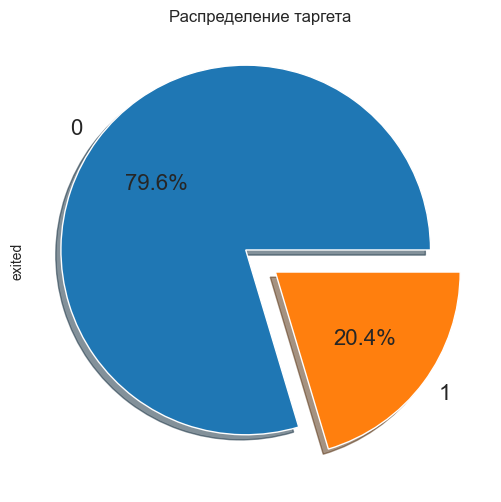

In [42]:
plt.figure(figsize=(6,6))

target.value_counts().plot.pie(explode=[0.1,0.1], 
                                             autopct='%1.1f%%', 
                                             shadow=True, 
                                             textprops={'fontsize':16}).set_title("Распределение таргета")
plt.show()

Целевой признак имеет дисбаланс классов 79.6% / 20.4% отрицательный класс / положительный.

### Модели без баланса классов

In [43]:
# составим сетки гиперпараметров для 3-х моделей
# в таком виде, чтобы можно было использовать с Pipeline
DecisionTree_param_grid = {
    'DecisionTree__criterion': ['gini', 'entropy', 'log_loss'],
    'DecisionTree__max_depth': range(2, 13),
    'DecisionTree__min_samples_split': range(2, 5),
    'DecisionTree__min_samples_leaf': range(1, 5)
}
    
RandomForest_param_grid = {
    'RandomForest__criterion': ['gini', 'entropy', 'log_loss'],
    'RandomForest__max_depth': range(2, 13),
    'RandomForest__min_samples_split': range(2, 5),
    'RandomForest__min_samples_leaf': range(1, 5)
}
    
LogisticRegression_param_grid = {
    'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'LogisticRegression__solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'LogisticRegression__max_iter': [50, 100, 150, 200, 250] 
}

In [44]:
scaler = StandardScaler()
pca = PCA()

In [45]:
# для скоринга беру 2 метрики: f1 и roc auc

scoring = {'f1': make_scorer(f1_score), 'AUC': make_scorer(roc_auc_score)}

#### 1. DecisionTree

In [46]:
%%time

dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)

pipe_dtree = Pipeline(steps=[("scaler", scaler), ('DecisionTree', dtree)])

search_dtree = GridSearchCV(pipe_dtree,
                       DecisionTree_param_grid,
                       n_jobs=2, 
                       cv=5, 
                       scoring=scoring,
                       refit='f1',
                       return_train_score=True)

search_dtree.fit(features_train, target_train)

CPU times: total: 375 ms
Wall time: 33 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DecisionTree',
                                        DecisionTreeClassifier(random_state=100500))]),
             n_jobs=2,
             param_grid={'DecisionTree__criterion': ['gini', 'entropy',
                                                     'log_loss'],
                         'DecisionTree__max_depth': range(2, 13),
                         'DecisionTree__min_samples_leaf': range(1, 5),
                         'DecisionTree__min_samples_split': range(2, 5)},
             refit='f1', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [47]:
search_dtree.best_score_

0.5847917005407772

In [48]:
# функция для вывода графика метрик f1, auc roc для train и test

def plot_f1_auc(model):
    results = pd.DataFrame(model.cv_results_)
    
    sns.set_theme(style='darkgrid')
    fig = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=results, x='mean_test_f1', y='mean_test_AUC', label = 'valid')
    sns.lineplot(data=results, x='mean_train_f1', y='mean_train_AUC', label = 'train')
    plt.title('F1 - AUC')
    plt.xlabel('F1')
    plt.ylabel('ROC AUC')
    plt.show()

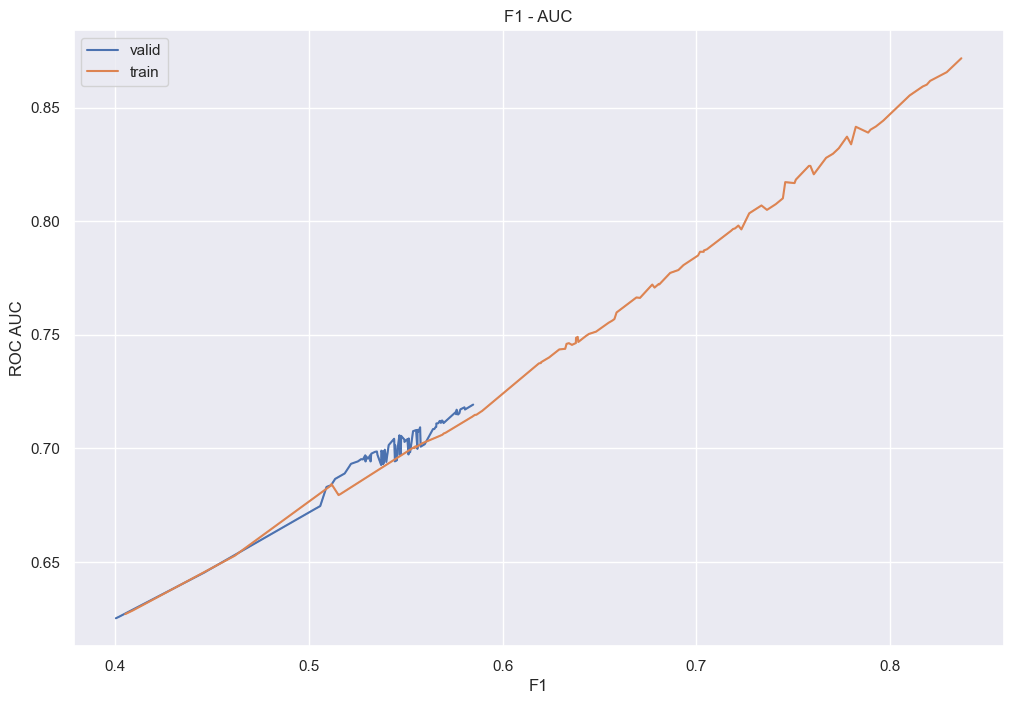

In [49]:
plot_f1_auc(search_dtree)

#### 2. RandomForest

In [50]:
%%time

rfor = RandomForestClassifier(random_state=RANDOM_STATE)

pipe_rfor = Pipeline(steps=[("scaler", scaler), ('RandomForest', rfor)])

search_rfor = RandomizedSearchCV(pipe_rfor,
                                       RandomForest_param_grid,
                                       n_iter=20,
                                       n_jobs=2, 
                                       cv=5, 
                                       scoring=scoring,
                                       refit='f1',
                                       return_train_score=True, 
                                       random_state=100500)

search_rfor.fit(features_train, target_train)

CPU times: total: 812 ms
Wall time: 37.7 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('RandomForest',
                                              RandomForestClassifier(random_state=100500))]),
                   n_iter=20, n_jobs=2,
                   param_distributions={'RandomForest__criterion': ['gini',
                                                                    'entropy',
                                                                    'log_loss'],
                                        'RandomForest__max_depth': range(2, 13),
                                        'RandomForest__min_samples_leaf': range(1, 5),
                                        'RandomForest__min_samples_split': range(2, 5)},
                   random_state=100500, refit='f1', return_train_score=True,
                   scoring={'AUC': make_scorer(roc_auc_score),
                            'f1': make_scorer(f1_score)})

In [51]:
search_rfor.best_score_

0.5762159211786522

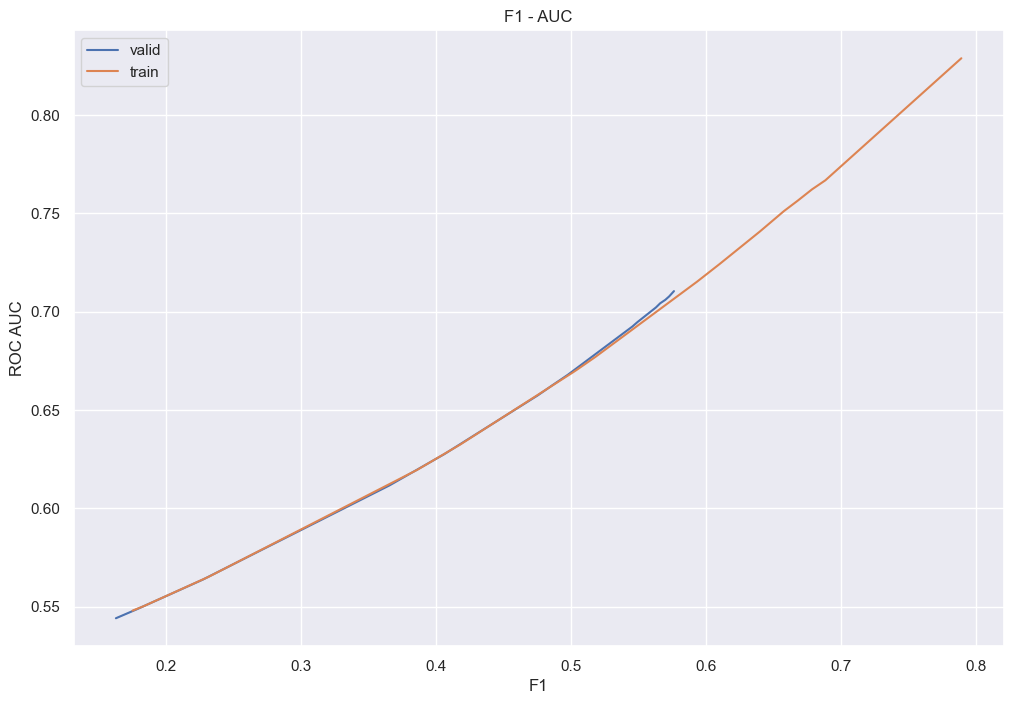

In [52]:
plot_f1_auc(search_rfor)

#### 3. LogisticRegression

In [53]:
log_reg = LogisticRegression(penalty='l2', max_iter=50, random_state=RANDOM_STATE)

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ('log_reg', log_reg)])

parameters = dict(pca__n_components=range(3, 12),
                      log_reg__C=[0.001, 0.01, 0.1, 1, 10, 100],
                     log_reg__solver=['lbfgs', 'liblinear', 'sag', 'saga'])

In [54]:
%%time

gs = GridSearchCV(pipe, parameters, cv=5, scoring=scoring, refit='f1', n_jobs=2, return_train_score=True)

gs.fit(features_train, target_train)

CPU times: total: 203 ms
Wall time: 20.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=50,
                                                           random_state=100500))]),
             n_jobs=2,
             param_grid={'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'log_reg__solver': ['lbfgs', 'liblinear', 'sag',
                                             'saga'],
                         'pca__n_components': range(3, 12)},
             refit='f1', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [55]:
gs.best_params_

{'log_reg__C': 1, 'log_reg__solver': 'liblinear', 'pca__n_components': 10}

In [56]:
gs.best_score_

0.31335211895625675

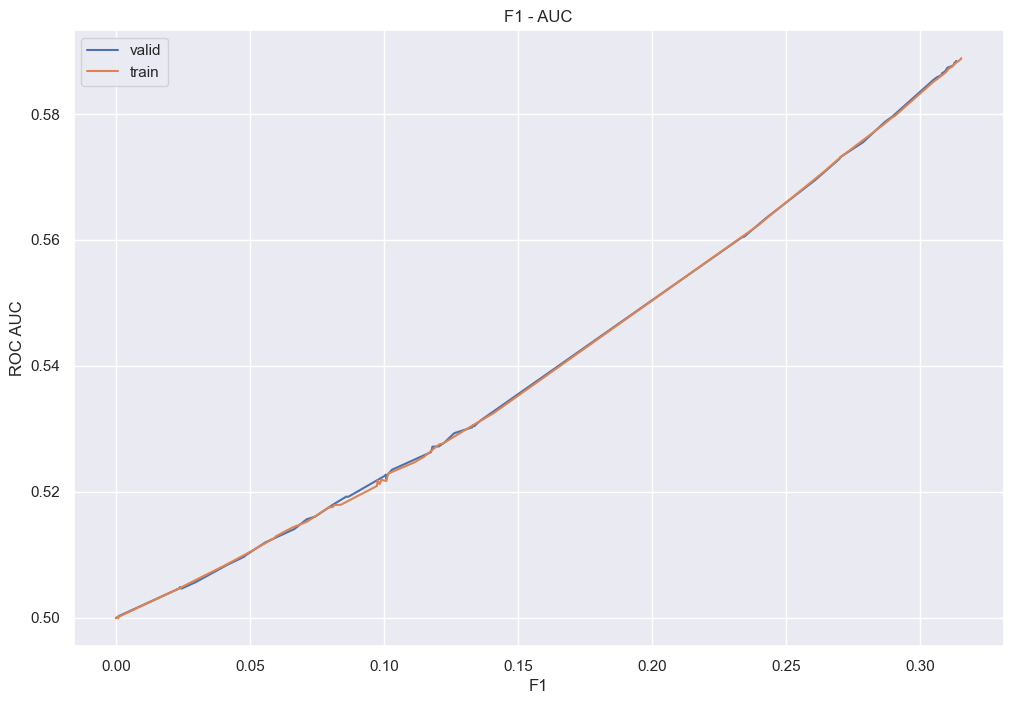

In [57]:
plot_f1_auc(gs)

#### Вывод

f1 у лог.регрессии имеет низкое значение - 0.313, auc roc = 0.585. У Дерева решений и Случайного леса метрики гораздо выше.    
На графиках f1-auc_roc практически сливаются кривые трейна и теста (условная валидационная выборка на кросс-валидации). С ростом f1 увеличивается auc roc.  

| Модель      | f1    | auc roc |
|-------------|-------|---------|
|Дерево решений| 0.585 |   0.752|
|Случайный лес|0.576| 0.821     |
|Лог.регрессия | 0.313 | 0.585   |

## Борьба с дисбалансом

### 1. Взвешивание классов

Проверим - какие значения метрик получатся у 3-х разных моделей - DecisionTree, RandomForest, LogisticRegression при использовании гиперпараметра class_weight='balanced'.

#### 1.1 DecisionTree

In [58]:
%%time

dtree_class = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipe_dtree_class = Pipeline(steps=[("scaler", scaler), ('DecisionTree', dtree_class)])

search_dtree_class = GridSearchCV(pipe_dtree_class,
                       DecisionTree_param_grid,
                       n_jobs=2, 
                       cv=5, 
                       scoring=scoring,
                       refit='f1',
                       return_train_score=True)

search_dtree_class.fit(features_train, target_train)

CPU times: total: 438 ms
Wall time: 45 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DecisionTree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=100500))]),
             n_jobs=2,
             param_grid={'DecisionTree__criterion': ['gini', 'entropy',
                                                     'log_loss'],
                         'DecisionTree__max_depth': range(2, 13),
                         'DecisionTree__min_samples_leaf': range(1, 5),
                         'DecisionTree__min_samples_split': range(2, 5)},
             refit='f1', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [59]:
search_dtree_class.best_score_

0.5705412250541164

In [60]:
search_dtree_class.best_params_

{'DecisionTree__criterion': 'entropy',
 'DecisionTree__max_depth': 7,
 'DecisionTree__min_samples_leaf': 4,
 'DecisionTree__min_samples_split': 2}

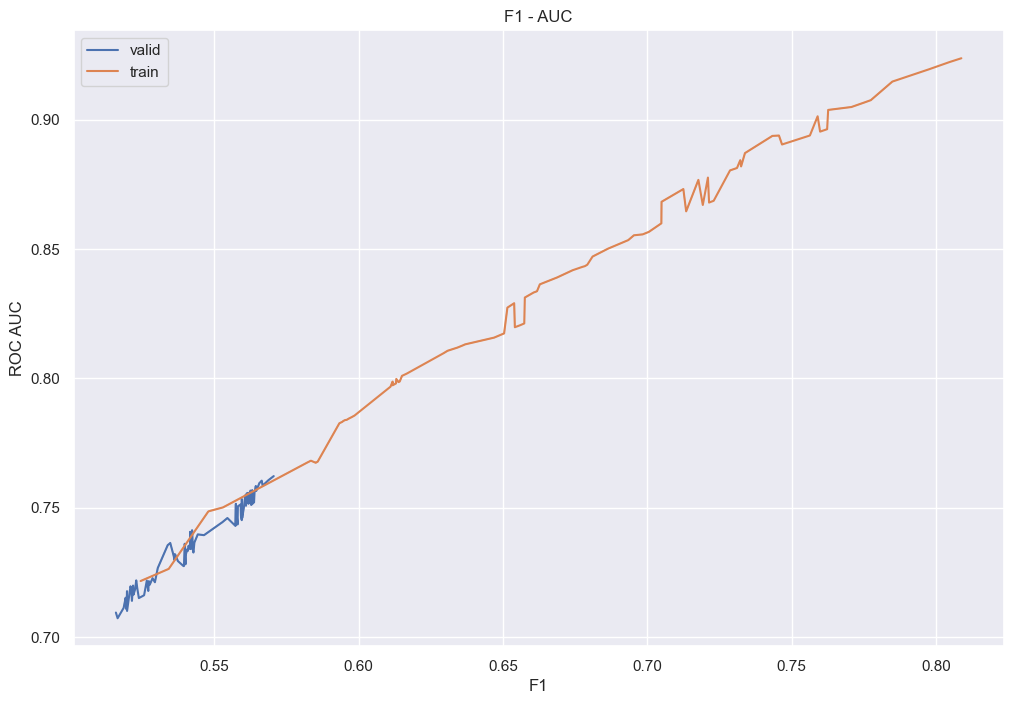

In [61]:
plot_f1_auc(search_dtree_class)

#### 1.2 RandomForest

In [62]:
%%time

rfor_class = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

pipe_rfor_class = Pipeline(steps=[("scaler", scaler), ('RandomForest', rfor_class)])

search_rfor_class = RandomizedSearchCV(pipe_rfor_class,
                                       RandomForest_param_grid,
                                       n_iter=20,
                                       n_jobs=2, 
                                       cv=5, 
                                       scoring=scoring,
                                       refit='f1',
                                       return_train_score=True, 
                                       random_state=100500)

search_rfor_class.fit(features_train, target_train)

CPU times: total: 656 ms
Wall time: 38.1 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('RandomForest',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=100500))]),
                   n_iter=20, n_jobs=2,
                   param_distributions={'RandomForest__criterion': ['gini',
                                                                    'entropy',
                                                                    'log_loss'],
                                        'RandomForest__max_depth': range(2, 13),
                                        'RandomForest__min_samples_leaf': range(1, 5),
                                        'RandomForest__min_samples_split': range(2, 5)},
                   random_state=100500, refit='f1', return_train_score=True,
                   scoring={'AUC': make_scorer(roc_auc_score),
                            'f1': make_scorer(f1_score)})

In [63]:
search_rfor_class.best_score_

0.6222469825674691

In [64]:
search_rfor_class.best_params_

{'RandomForest__min_samples_split': 3,
 'RandomForest__min_samples_leaf': 3,
 'RandomForest__max_depth': 10,
 'RandomForest__criterion': 'gini'}

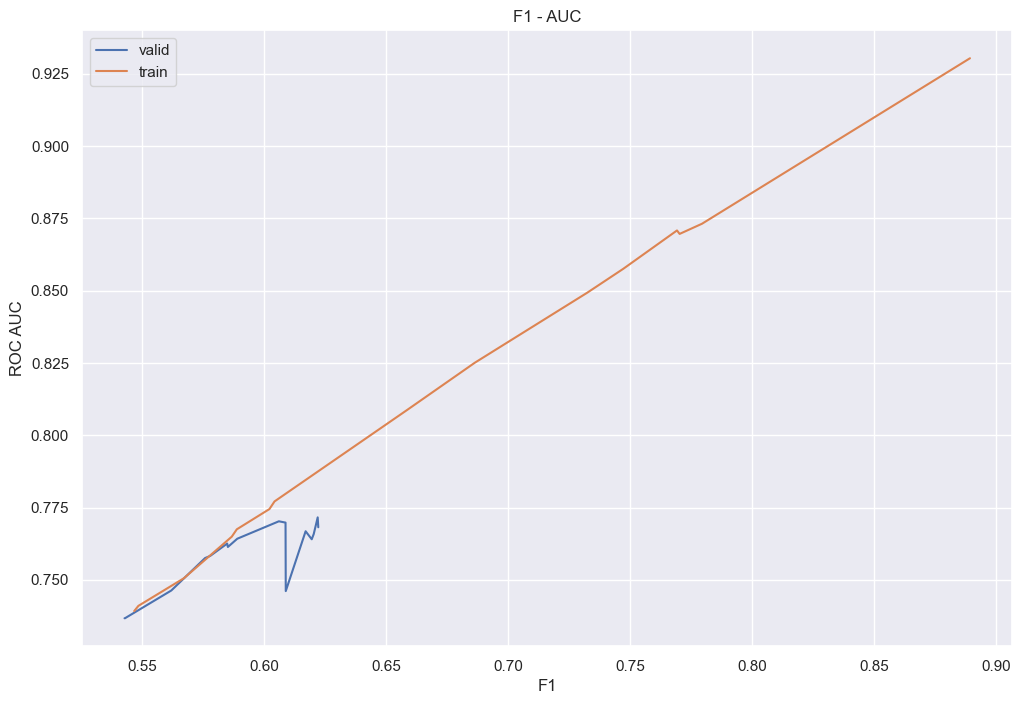

In [65]:
plot_f1_auc(search_rfor_class)

#### 1.3 LogisticRegression

In [66]:
%%time

logreg_class = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

pipe_logreg_class = Pipeline(steps=[("scaler", scaler), ("pca", pca), ('LogisticRegression', logreg_class)])
    
search_logreg_class = GridSearchCV(pipe_logreg_class,
                       LogisticRegression_param_grid,
                       n_jobs=2, 
                       cv=5, 
                       scoring=scoring,
                       refit='f1',
                       return_train_score=True)

search_logreg_class.fit(features_train, target_train)

CPU times: total: 203 ms
Wall time: 16.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('LogisticRegression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=100500))]),
             n_jobs=2,
             param_grid={'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'LogisticRegression__max_iter': [50, 100, 150, 200,
                                                          250],
                         'LogisticRegression__solver': ['lbfgs', 'liblinear',
                                                        'sag', 'saga',
                                                        'newton-cg']},
             refit='f1', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [67]:
search_logreg_class.best_score_

0.4960621552921115

In [68]:
search_logreg_class.best_params_

{'LogisticRegression__C': 0.01,
 'LogisticRegression__max_iter': 50,
 'LogisticRegression__solver': 'lbfgs'}

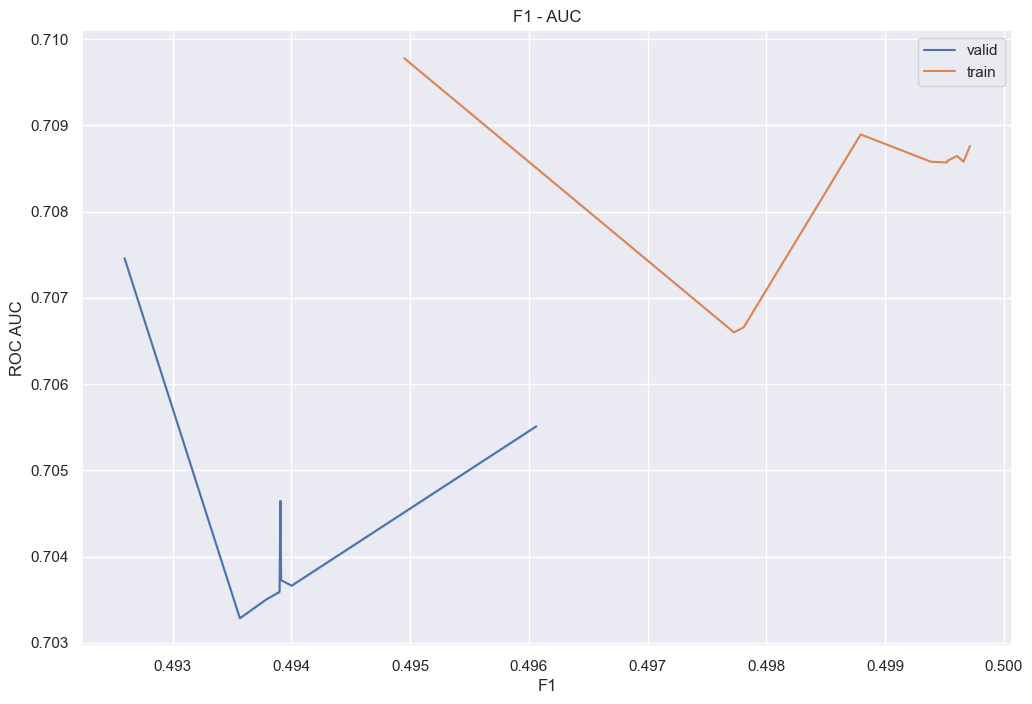

In [69]:
plot_f1_auc(search_logreg_class)

**Метрики моделей при class_weight='balanced'**  

| Модель      | f1    | auc roc |
|-------------|-------|---------|
|DecisionTree|0.585|0.752|
|DecisionTree + class_weight | 0.571 | 0.800   |
|RandomForest|0.576|0.821|
|RandomForest + class_weight| 0.622| 0.877 |
|LogisticRegression|0.313|0.585|
|LogisticRegression + class_weight|0.496 |0.708|

f1 и auc roc выросли у Случайного леса и Логистич. регрессии по сравнению с моделями без учета дисбаланса классов. А вот у модели Дерево решений f1 оказалось выше без баланса классов (0.585 vs 0.571), при этом auc_roc выше у Дерева решений со взвешиванием классов (0.752 vs 0.800).

### 2. Upsampling

Для генерации объектов положительного класса будем использовать метод `smote`.

In [70]:
smote = SMOTE(random_state=RANDOM_STATE)

#### 2.1 DecisionTree

In [71]:
%%time

dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)

pipe_dtree_smote = Pipeline(steps=[("scaler", scaler), ('smote', smote), ('DecisionTree', dtree)])

search_dtree_smote = GridSearchCV(pipe_dtree_smote,
                       DecisionTree_param_grid,
                       n_jobs=2, 
                       cv=5, 
                       scoring=scoring,
                       refit='f1',
                       return_train_score=True)

search_dtree_smote.fit(features_train, target_train)

CPU times: total: 1.16 s
Wall time: 1min 32s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=100500)),
                                       ('DecisionTree',
                                        DecisionTreeClassifier(random_state=100500))]),
             n_jobs=2,
             param_grid={'DecisionTree__criterion': ['gini', 'entropy',
                                                     'log_loss'],
                         'DecisionTree__max_depth': range(2, 13),
                         'DecisionTree__min_samples_leaf': range(1, 5),
                         'DecisionTree__min_samples_split': range(2, 5)},
             refit='f1', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [72]:
search_dtree_smote.best_score_

0.5839693404123354

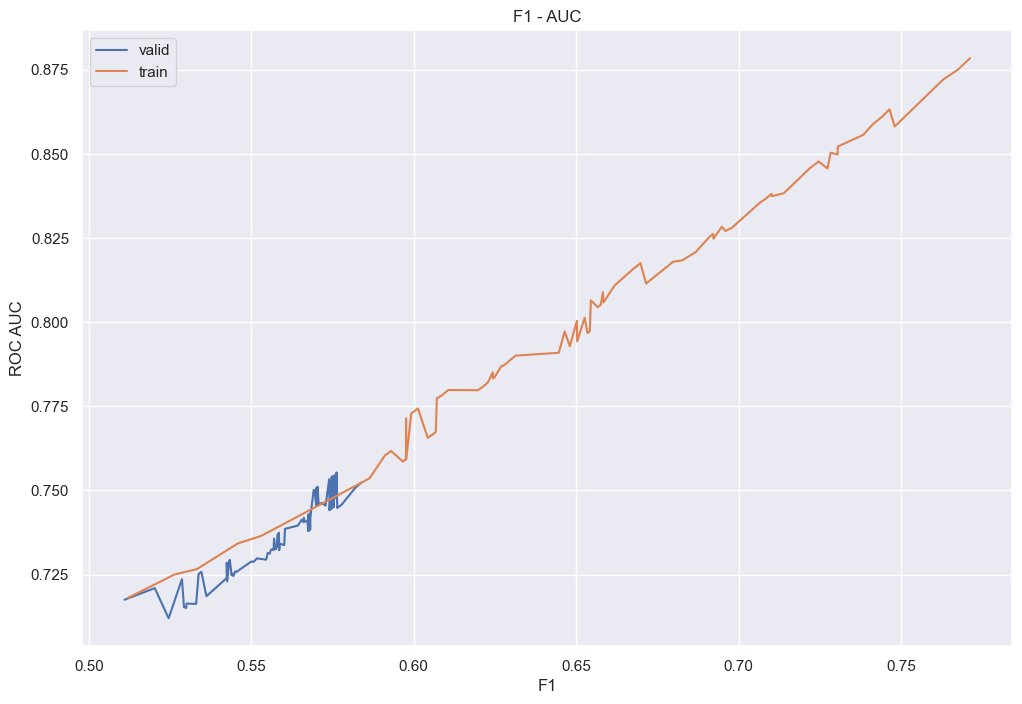

In [73]:
plot_f1_auc(search_dtree_smote)

#### 2.2 RandomForest 

In [74]:
%%time

rfor = RandomForestClassifier(random_state=RANDOM_STATE)

pipe_rfor_smote = Pipeline(steps=[("scaler", scaler), ('smote', smote), ('RandomForest', rfor)])

search_rfor_smote = RandomizedSearchCV(pipe_rfor_smote,
                                       RandomForest_param_grid,
                                       n_iter=20,
                                       n_jobs=2, 
                                       cv=5, 
                                       scoring=scoring,
                                       refit='f1',
                                       return_train_score=True, 
                                       random_state=100500,
                                      verbose=1)

search_rfor_smote.fit(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 1.27 s
Wall time: 1min 8s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote',
                                              SMOTE(random_state=100500)),
                                             ('RandomForest',
                                              RandomForestClassifier(random_state=100500))]),
                   n_iter=20, n_jobs=2,
                   param_distributions={'RandomForest__criterion': ['gini',
                                                                    'entropy',
                                                                    'log_loss'],
                                        'RandomForest__max_depth': range(2, 13),
                                        'RandomForest__min_samples_leaf': range(1, 5),
                                        'RandomForest__min_samples_split': range(2, 5)},
                   random_state=100500, refit='f1', return_train_score=True,
                   scoring={'AUC': make_scorer(roc_auc_score),
                            'f1': make_scorer(f1_score)},
                   verbose=1)

In [75]:
search_rfor_smote.best_score_

0.6115274044155956

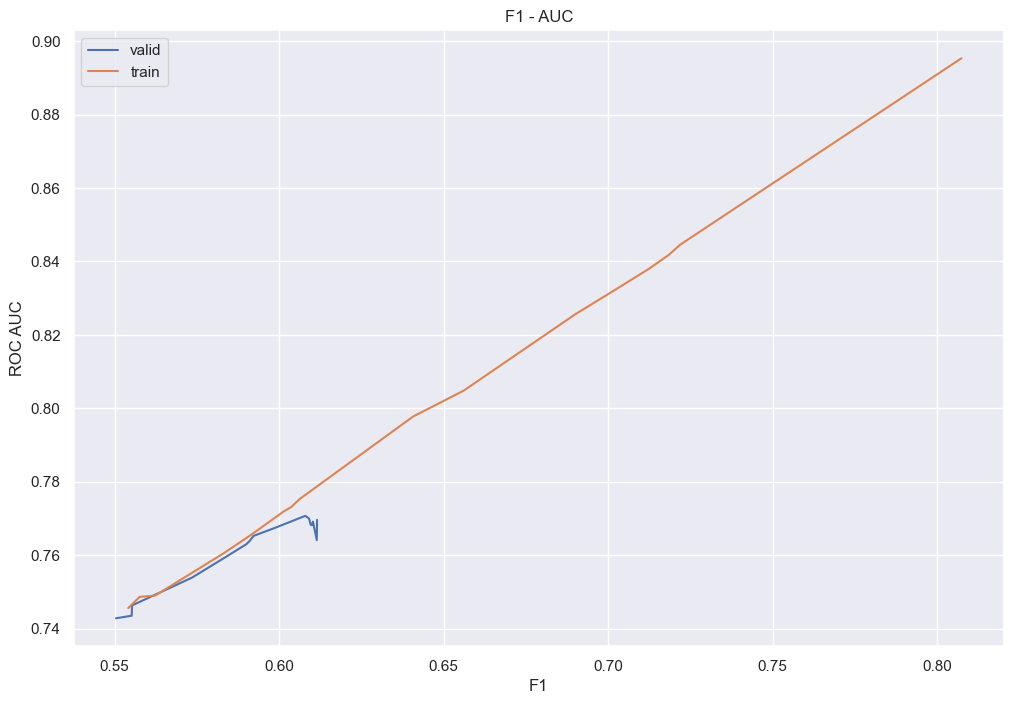

In [76]:
plot_f1_auc(search_rfor_smote)

#### 2.3 LogisticRegression

In [77]:
%%time

logreg = LogisticRegression(random_state=RANDOM_STATE)

pipe_logreg_smote = Pipeline(steps=[("scaler", scaler), ("pca", pca), ('smote', smote), ('LogisticRegression', logreg)])
    
search_logreg_smote = GridSearchCV(pipe_logreg_smote,
                       LogisticRegression_param_grid,
                       n_jobs=2, 
                       cv=5, 
                       scoring=scoring,
                       refit='f1',
                       return_train_score=True,
                       verbose=2)

search_logreg_smote.fit(features_train, target_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
CPU times: total: 281 ms
Wall time: 34.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('smote', SMOTE(random_state=100500)),
                                       ('LogisticRegression',
                                        LogisticRegression(random_state=100500))]),
             n_jobs=2,
             param_grid={'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'LogisticRegression__max_iter': [50, 100, 150, 200,
                                                          250],
                         'LogisticRegression__solver': ['lbfgs', 'liblinear',
                                                        'sag', 'saga',
                                                        'newton-cg']},
             refit='f1', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)},
             verbose=2)

In [78]:
search_logreg_smote.best_score_

0.494984846917465

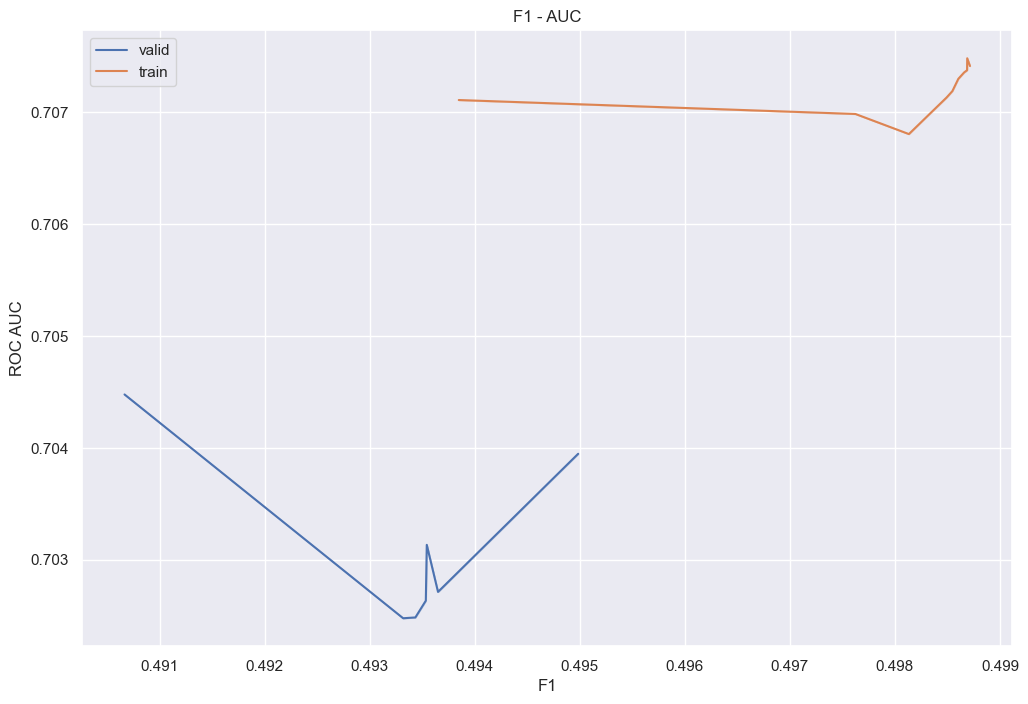

In [79]:
plot_f1_auc(search_logreg_smote)

**Метрики моделей с smote**

| Модель      | f1    | auc roc |
|-------------|-------|---------|
|DecisionTree|0.585|0.752|
|DecisionTree + smote | 0.584 | 0.749   |
|RandomForest|0.576|0.821|
|RandomForest + smote| 0.612| 0.827 |
|LogisticRegression|0.313|0.585|
|LogisticRegression + smote|0.495 |0.705|

Дерево решений без баланса классов показывает немного лучше метрики, чес со smote. Для лог.регрессии метод smote значительно улучшил метрики, чем у модели без баланса классов.

### 3 Изменение порога

Для того, чтобы использовать метод изменения порога, нам понадобится отдельная валидационная выборка. До этого мы пользовались кросс-валидацией на train. Разделим train на train_new и valid.

In [80]:
features_train_new, features_valid, target_train_new, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=RANDOM_STATE, stratify=target_train)

#### 3.1 DecisionTree

In [81]:
# функция для построения графика PR-curve и таблички с порогом

def plot_pr_and_search_threshold(model):
    probabilities_valid = model.best_estimator_.predict_proba(features_valid)
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
    F1 = (2 * precision * recall) / (precision + recall)

    plt.figure(figsize=(8, 8))
    plt.plot(thresholds, precision[: -1] , c = 'r' , label = 'Precision' )
    plt.plot(thresholds, recall[: -1] , c = 'b' , label = 'Recall' )
    plt.plot(thresholds, F1[: -1], c = 'g', label = 'f1')
    plt.legend()
    plt.title( 'Precision-Recall Curve' )
    plt.show()
    
    for threshold in np.arange(0, 0.4, 0.02):
        predicted_valid = probabilities_valid[:, 1] > threshold
        precision = precision_score(target_valid, predicted_valid) 
        recall = recall_score(target_valid, predicted_valid)
        f1 = f1_score(target_valid, predicted_valid)
        roc_auc = roc_auc_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f} | f1 = {:.3f} | roc auc = {:.3f}".format(
            threshold, precision, recall, f1, roc_auc))

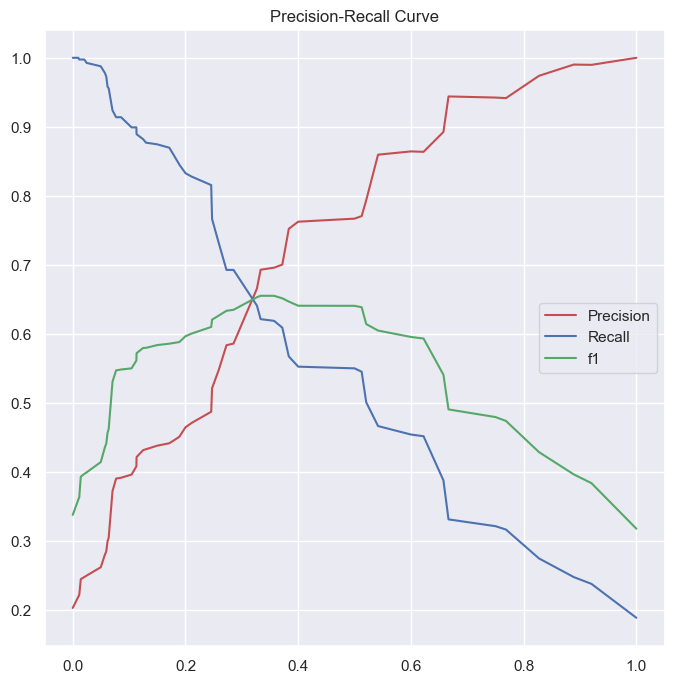

Порог = 0.00 | Точность = 0.220 | Полнота = 1.000 | f1 = 0.360 | roc auc = 0.546
Порог = 0.02 | Точность = 0.248 | Полнота = 0.998 | f1 = 0.397 | roc auc = 0.613
Порог = 0.04 | Точность = 0.262 | Полнота = 0.988 | f1 = 0.415 | roc auc = 0.639
Порог = 0.06 | Точность = 0.300 | Полнота = 0.958 | f1 = 0.457 | roc auc = 0.693
Порог = 0.08 | Точность = 0.392 | Полнота = 0.914 | f1 = 0.549 | roc auc = 0.776
Порог = 0.10 | Точность = 0.397 | Полнота = 0.899 | f1 = 0.550 | roc auc = 0.775
Порог = 0.12 | Точность = 0.432 | Полнота = 0.882 | f1 = 0.580 | roc auc = 0.793
Порог = 0.14 | Точность = 0.438 | Полнота = 0.875 | f1 = 0.584 | roc auc = 0.794
Порог = 0.16 | Точность = 0.442 | Полнота = 0.870 | f1 = 0.586 | roc auc = 0.795
Порог = 0.18 | Точность = 0.450 | Полнота = 0.848 | f1 = 0.588 | roc auc = 0.792
Порог = 0.20 | Точность = 0.471 | Полнота = 0.828 | f1 = 0.601 | roc auc = 0.795
Порог = 0.22 | Точность = 0.488 | Полнота = 0.816 | f1 = 0.610 | roc auc = 0.798
Порог = 0.24 | Точность = 0.

In [82]:
plot_pr_and_search_threshold(search_dtree)

При пороге 0.34 - наилучший показатель метрики f1 и достаточно высокий roc_auc.

In [83]:
# проверим метрики на тестовой выборке с изменением порога

def change_threshold(model, threshold):
    
    preds = np.where(model.best_estimator_.predict_proba(features_test)[:,1] >= threshold, 1, 0)

    return pd.DataFrame(data=[recall_score(target_test, preds), precision_score(target_test, preds), 
                           f1_score(target_test, preds), roc_auc_score(target_test, preds)], 
                           index=["recall", "precision", "f1", "roc_auc_score"],
                           columns = ['метрики на тесте']).round(3)

In [84]:
dtree_test = change_threshold(search_dtree, 0.34)
dtree_test

,метрики на тесте
recall,0.575
precision,0.616
f1,0.595
roc_auc_score,0.742


#### 3.2 RandomForest 

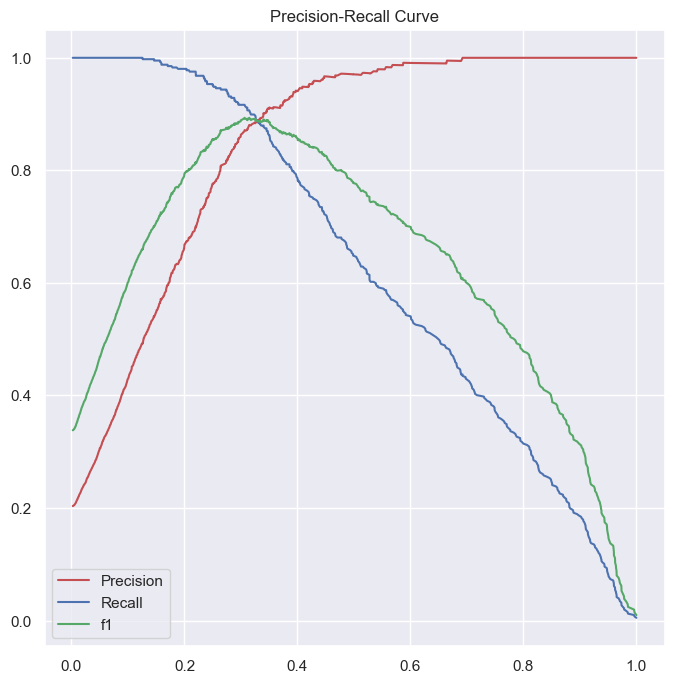

Порог = 0.00 | Точность = 0.203 | Полнота = 1.000 | f1 = 0.338 | roc auc = 0.500
Порог = 0.02 | Точность = 0.237 | Полнота = 1.000 | f1 = 0.383 | roc auc = 0.588
Порог = 0.04 | Точность = 0.279 | Полнота = 1.000 | f1 = 0.436 | roc auc = 0.669
Порог = 0.06 | Точность = 0.328 | Полнота = 1.000 | f1 = 0.494 | roc auc = 0.739
Порог = 0.08 | Точность = 0.375 | Полнота = 1.000 | f1 = 0.546 | roc auc = 0.787
Порог = 0.10 | Точность = 0.430 | Полнота = 1.000 | f1 = 0.601 | roc auc = 0.831
Порог = 0.12 | Точность = 0.481 | Полнота = 1.000 | f1 = 0.650 | roc auc = 0.862
Порог = 0.14 | Точность = 0.528 | Полнота = 0.998 | f1 = 0.690 | roc auc = 0.885
Порог = 0.16 | Точность = 0.573 | Полнота = 0.988 | f1 = 0.725 | roc auc = 0.900
Порог = 0.18 | Точность = 0.622 | Полнота = 0.983 | f1 = 0.762 | roc auc = 0.915
Порог = 0.20 | Точность = 0.667 | Полнота = 0.980 | f1 = 0.794 | roc auc = 0.928
Порог = 0.22 | Точность = 0.698 | Полнота = 0.973 | f1 = 0.813 | roc auc = 0.933
Порог = 0.24 | Точность = 0.

In [85]:
plot_pr_and_search_threshold(search_rfor)

In [86]:
rfor_test = change_threshold(search_rfor, 0.32)
rfor_test

,метрики на тесте
recall,0.624
precision,0.624
f1,0.624
roc_auc_score,0.764


#### 3.3 LogisticRegression

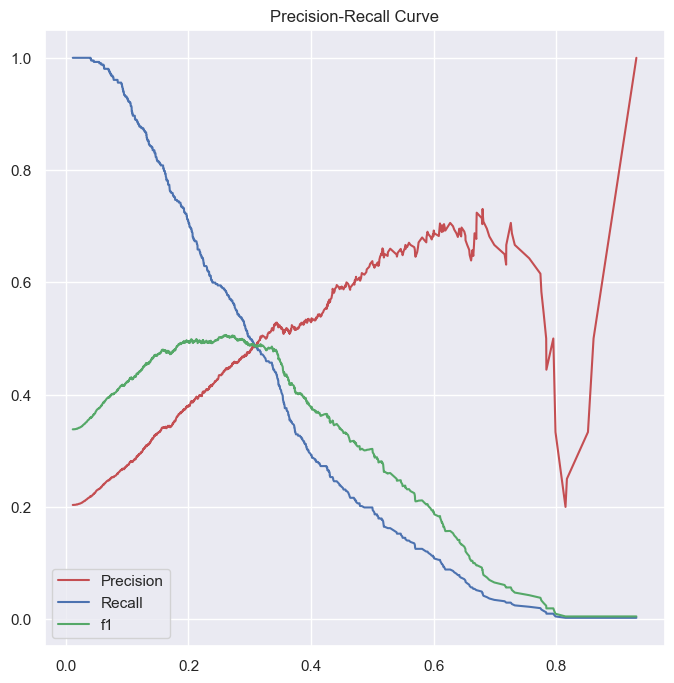

Порог = 0.00 | Точность = 0.203 | Полнота = 1.000 | f1 = 0.338 | roc auc = 0.500
Порог = 0.02 | Точность = 0.205 | Полнота = 1.000 | f1 = 0.340 | roc auc = 0.504
Порог = 0.04 | Точность = 0.219 | Полнота = 1.000 | f1 = 0.359 | roc auc = 0.544
Порог = 0.06 | Точность = 0.239 | Полнота = 0.988 | f1 = 0.384 | roc auc = 0.591
Порог = 0.08 | Точность = 0.255 | Полнота = 0.961 | f1 = 0.403 | roc auc = 0.622
Порог = 0.10 | Точность = 0.274 | Полнота = 0.929 | f1 = 0.423 | roc auc = 0.650
Порог = 0.12 | Точность = 0.295 | Полнота = 0.880 | f1 = 0.441 | roc auc = 0.671
Порог = 0.14 | Точность = 0.319 | Полнота = 0.840 | f1 = 0.463 | roc auc = 0.691
Порог = 0.16 | Точность = 0.342 | Полнота = 0.801 | f1 = 0.479 | roc auc = 0.704
Порог = 0.18 | Точность = 0.358 | Полнота = 0.747 | f1 = 0.484 | roc auc = 0.702
Порог = 0.20 | Точность = 0.379 | Полнота = 0.708 | f1 = 0.494 | roc auc = 0.706
Порог = 0.22 | Точность = 0.398 | Полнота = 0.649 | f1 = 0.493 | roc auc = 0.699
Порог = 0.24 | Точность = 0.

In [87]:
plot_pr_and_search_threshold(gs)

Выберем порог 0.26, т.к. при этом пороге у нас наибольшая f1.

In [88]:
gs_test = change_threshold(gs, 0.26)
gs_test

,метрики на тесте
recall,0.580
precision,0.424
f1,0.490
roc_auc_score,0.689


#### Вывод

Сравнение метрик моделей без баланса и с изменением порога на тестовой выборке.    


| Модель      | f1    | auc roc |
|-------------|-------|---------|
|Дерево решений| 0.578 |   0.721|
|Дерево реш. с порогом 0.34|0.595|0.742|
|Случайный лес|0.554| 0.700     |
|Случайный лес с порогом 0.32|0.624 | 0.764|
|Лог.регрессия | 0.326 | 0.593   |
|Лог.регрессия с порогом 0.26| 0.490| 0.689 |

### DummyClassifier

Сравним наши модели с самым простым предсказанием - Dummy.

In [89]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy_clf.fit(features_train, target_train)
dummy_pred = dummy_clf.predict(features_test)

Метрики Dummy посчитаем в следующем разделе на тестовой выборке и внесем их в общую таблицу.

### Метрики по моделям

In [90]:
# создадим словарь с названиями моделей и их переменными

models = {'Дерево реш. без баланса': search_dtree,
         'Случайный лес без баланса': search_rfor,
         'Лог.регрессия без баланса': gs,
         'Дерево реш. с class_weight': search_dtree_class,
         'Случайный лес с class_weight': search_rfor_class,
         'Лог.регрессия с class_weight': search_logreg_class,
         'Дерево реш. с smote': search_dtree_smote,
         'Случайный лес с smote': search_rfor_smote,
         'Лог.регрессия с smote': search_logreg_smote}

In [91]:
# создадим датафрейм с моделями и метриками (пока заполненные нулями)

scores = pd.DataFrame({'classifier': models.keys(),
                      'f1_valid': np.zeros(len(models)),
                      'roc_auc_valid': np.zeros(len(models)),
                      'f1_test': np.zeros(len(models)),
                      'roc_auc_test': np.zeros(len(models))})

In [92]:
# начнем заполнять фрейм с метриками

i = 0

for model in models.values():
    scores.iloc[i, 1] = model.best_score_
    
    predict_valid = model.best_estimator_.predict(features_valid)
    
    scores.iloc[i, 2] = roc_auc_score(target_valid, predict_valid)
    
    predict_test = model.best_estimator_.predict(features_test)
    scores.iloc[i, 3] = f1_score(target_test, predict_test)
    scores.iloc[i, 4] = roc_auc_score(target_test, predict_test)
    
    i += 1
    
scores = scores.round(4)

In [93]:
# создадим фрейм с 4-мя оставшимися моделями и их метриками, которые не могли заполнить с помощью цикла

rows = pd.DataFrame({'classifier': ['Дерево реш. с threshold=0.34', 'Случайный лес с threshold=0.32', 'Лог.регрессия с threshold=0.26', 'DummyClassifier'],
                                          'f1_valid': ['-', '-', '-', '-'], 
                                          'roc_auc_valid': ['-', '-', '-', '-'],
                                          'f1_test': [dtree_test.iloc[2,0], rfor_test.iloc[2,0], gs_test.iloc[2,0], f1_score(target_test, dummy_pred)], 
                                          'roc_auc_test': [dtree_test.iloc[3,0], rfor_test.iloc[3,0], gs_test.iloc[3,0], roc_auc_score(target_test, dummy_pred)]})
rows                    

,classifier,f1_valid,roc_auc_valid,f1_test,roc_auc_test
0,Дерево реш. с threshold=0.34,-,-,0.595000,0.742000
1,Случайный лес с threshold=0.32,-,-,0.624000,0.764000
2,Лог.регрессия с threshold=0.26,-,-,0.490000,0.689000
3,DummyClassifier,-,-,0.201743,0.500639


In [94]:
# соединим 2 фрейма
scores = pd.concat([scores, rows], ignore_index=True)
scores = scores.set_index('classifier').round(4)
scores

,f1_valid,roc_auc_valid,f1_test,roc_auc_test
classifier,,,,
Дерево реш. без баланса,0.5848,0.752,0.5775,0.7211
Случайный лес без баланса,0.5762,0.8206,0.5535,0.6996
Лог.регрессия без баланса,0.3134,0.5851,0.3262,0.5926
Дерево реш. с class_weight,0.5705,0.7999,0.5882,0.7798
Случайный лес с class_weight,0.6222,0.8771,0.6259,0.7739
Лог.регрессия с class_weight,0.4961,0.7083,0.4983,0.7100
Дерево реш. с smote,0.584,0.749,0.5723,0.7467
Случайный лес с smote,0.6115,0.8268,0.6243,0.7781
Лог.регрессия с smote,0.495,0.7053,0.5022,0.7125


#### Вывод

Дисбаланс классов влияет на качество модели.  

Дерево решений - единственная модель, у которой метрики f1 и auc_roc не сильно отличаются при дисбалансе и балансе.  

Модель лог.регрессии без учета дисбаланса классов показала наихудший результат, но все равно оказалась лучше Dummy модели.   

Наилучшая модель - Случайный лес с class_weight='balanced' с метриками на трейне: f1=0.62  и roc_auc=0.88 и на тесте: f1=0.63 и roc_auc=0.77.